# Librerías

In [39]:
import ast
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Descargamos el json

Para eso leemos el archivo australian_user_reviews.json con la libreria ast y lo convertimos en un DataFrame de pandas para poder manejarlo

In [2]:
# Leemos el contenido del archivo "australian_user_reviews.json"
aus_user_reviews = []
with open('australian_user_reviews.json', 'r', encoding='utf-8') as file:
    for line in file.readlines():
        aus_user_reviews.append(ast.literal_eval(line))

# Creamos el DataFrame "df_user_reviews"
user_reviews_original = pd.DataFrame(aus_user_reviews)

Creamos una copia para poder manejarla con mayor tranquilidad y por cualquier error no tener que descargar nuevamente los datos

In [3]:
user_reviews = user_reviews_original.copy()

Hacemos una primera revision de los datos, para saber cantidad de registros y si hay datos vacíos o nulos.

In [4]:
print(f'Formato del DataFrame: {user_reviews.shape}')
user_reviews.info()

Formato del DataFrame: (25799, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [5]:
user_reviews.head(2)

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."


# Desanidamos la columna reviews

Utilizamos primero un .explode() para lograr tener una review por fila y desanidamos el diccionario creando nuevas columnas para ver los valores.

In [6]:
user_reviews = user_reviews.explode('reviews')

user_reviews = pd.concat([user_reviews.drop('reviews', axis=1), 
                        user_reviews['reviews'].apply(pd.Series)], axis=1)

In [7]:
user_reviews.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review,0
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,NaN
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,NaN
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,NaN
1,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,NaN
1,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,NaN


# Limpieza de columnas

Vemos algunas columnas que creemos que no son necesarias para el proyecto, pero primero las analizamos y vemos su informacion.

In [8]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59333 entries, 0 to 25798
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      59333 non-null  object 
 1   user_url     59333 non-null  object 
 2   funny        59305 non-null  object 
 3   posted       59305 non-null  object 
 4   last_edited  59305 non-null  object 
 5   item_id      59305 non-null  object 
 6   helpful      59305 non-null  object 
 7   recommend    59305 non-null  object 
 8   review       59305 non-null  object 
 9   0            0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 5.0+ MB


En primer lugar vemos que hay una columna '0' que no tiene informacion por lo que la eliminamos. Ademas, decidimos eliminar las columnas que no nos aportan valor.

In [9]:
user_reviews.drop(columns=[0, 'user_url', 'funny', 'last_edited', 'helpful'], axis=1,inplace=True)

In [10]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59333 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59333 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.7+ MB


A traves del .info() nos damos cuenta que hay 28 registros que no tienen informacion relevante por lo que decidimos revisarlos.

In [11]:
df_prueba = user_reviews[user_reviews['posted'].isnull()]
df_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 62 to 25001
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    28 non-null     object
 1   posted     0 non-null      object
 2   item_id    0 non-null      object
 3   recommend  0 non-null      object
 4   review     0 non-null      object
dtypes: object(5)
memory usage: 1.3+ KB


Viendo que no tienen datos decidimos eliminarlos del user_reviews. Por esto, realizamos entonces un dropna de la columna 'posted' ya que vemos que tampoco tiene ningun otro tipo de informacion que valga la pena conservar.

In [12]:
user_reviews = user_reviews.dropna(subset=['posted'])
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59305 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.7+ MB


# Columna posted

Como unicamente nos interesa la informacion del anio de posteo, realizamos algunas modificaciones.

In [13]:
user_reviews.head()

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
0,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
0,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
1,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
1,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...


Primero eliminamos la palabra 'Posted ' del principio de la celda, eliminamos el '.' final y la ',' para poder separar los datos en diferentes columnas

In [14]:
user_reviews['posted'] = user_reviews['posted'].str.replace('Posted ', '').str.replace('.', '').str.replace(',', '')

Dividimos entonces la columna en 3 para tener el mes, dia y anio por separado. 

In [15]:
user_reviews[['month', 'day', 'year_posted']] = user_reviews['posted'].str.split(' ', expand=True)

In [16]:
user_reviews.head()

,user_id,posted,item_id,recommend,review,month,day,year_posted
0,76561197970982479,November 5 2011,1250,True,Simple yet with great replayability. In my opi...,November,5,2011
0,76561197970982479,July 15 2011,22200,True,It's unique and worth a playthrough.,July,15,2011
0,76561197970982479,April 21 2011,43110,True,Great atmosphere. The gunplay can be a bit chu...,April,21,2011
1,js41637,June 24 2014,251610,True,I know what you think when you see this title ...,June,24,2014
1,js41637,September 8 2013,227300,True,For a simple (it's actually not all that simpl...,September,8,2013


Eliminamos las columnas que ya no necesitamos

In [17]:
user_reviews = user_reviews.drop(columns=['posted', 'month', 'day'], axis=1)

In [18]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      59305 non-null  object
 1   item_id      59305 non-null  object
 2   recommend    59305 non-null  object
 3   review       59305 non-null  object
 4   year_posted  49186 non-null  object
dtypes: object(5)
memory usage: 2.7+ MB


Vemos que hay mas de 10.000 registros que no tienen informacion acerca del anio de posteo, pero analizando las consultas que se nos piden, no nos aporta informacion de valor para esta ocasion, por lo que decidimos dejarlo como esta.

# Feature Engeneering

En el dataset se incluyen reseñas de juegos hechos por distintos usuarios. 
Creamos entonces una columna 'sentiment_analysis' aplicando análisis de sentimiento con las libreria nltk con la funcion 'SentimentIntensityAnalyzer' y la siguiente escala: 

- Toma el valor '0' si es malo
- Toma el valor '1' si es neutral 
- Toma el valor '2' si es positivo

De no ser posible este análisis por estar ausente la reseña escrita, debe tomar el valor de 1.

## Descargamos el vader_lexicon

El VADER puede determinar si una oración o un documento tiene un sentimiento positivo, negativo o neutro.

In [19]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natiq\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Creamos una funcion 'categorize_review' para que nos indique en que valor de la escala se encuentra la review.

In [20]:
def categorize_review(review):
    if review == '':
        return 1  # Neutral si está vacía
    else:
        # Analiza el sentimiento utilizando Vader
        sid = SentimentIntensityAnalyzer()
        sentiment_score = sid.polarity_scores(review)
        
        # Asignar categorías basadas en el sentimiento
        if sentiment_score['compound'] >= 0.3:
            return 2  # Buena
        elif sentiment_score['compound'] <= -0.3:
            return 0  # Mala
        else:
            return 1  # Neutral

Aplicamos la funcion a la columna review y creamos la columna sentiment_analysis

In [21]:
user_reviews['sentiment_analysis'] = user_reviews['review'].apply(categorize_review)

In [22]:
user_reviews.head()

,user_id,item_id,recommend,review,year_posted,sentiment_analysis
0,76561197970982479,1250,True,Simple yet with great replayability. In my opi...,2011,2
0,76561197970982479,22200,True,It's unique and worth a playthrough.,2011,1
0,76561197970982479,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011,2
1,js41637,251610,True,I know what you think when you see this title ...,2014,2
1,js41637,227300,True,For a simple (it's actually not all that simpl...,2013,2


Eliminamos la columna review ya que ya no nos sirve. 

In [23]:
user_reviews = user_reviews.drop(columns=['review'], axis=1)

Revisamos como nos quedo distribuida la columna

In [24]:
user_reviews.sentiment_analysis.value_counts()

sentiment_analysis
2    34406
1    17605
0     7294
Name: count, dtype: int64

In [50]:
user_reviews['item_id'] = user_reviews['item_id'].astype(int)
user_reviews['recommend'] = user_reviews['recommend'].astype(bool)

# EDA

Realizamos un breve analisis de los datos

In [51]:
user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59305 entries, 0 to 25798
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             59305 non-null  object
 1   item_id             59305 non-null  int32 
 2   recommend           59305 non-null  bool  
 3   year_posted         49186 non-null  object
 4   sentiment_analysis  59305 non-null  int64 
dtypes: bool(1), int32(1), int64(1), object(2)
memory usage: 2.1+ MB


Para esto vamos a filtrar por las columnas a analizar

In [52]:
df_rev = user_reviews[['item_id', 'recommend', 'sentiment_analysis']]

Convertimos la columna 'sentiment_analysis' en dummies para poder luego contabilizar cantidades

In [53]:
df_dummies = pd.get_dummies(df_rev['sentiment_analysis'])
df_dummies = df_dummies.rename(columns={0: 'Negativas', 1: 'Neutras', 2:'Positivas'})
df_rev = pd.concat([df_rev, df_dummies], axis=1)

In [54]:
df_rev.drop(columns=['sentiment_analysis'], axis=1, inplace=True)

In [55]:
df_rev

,item_id,recommend,Negativas,Neutras,Positivas
0,1250,True,False,False,True
0,22200,True,False,True,False
0,43110,True,False,False,True
1,251610,True,False,False,True
1,227300,True,False,False,True
...,...,...,...,...,...
25797,70,True,False,False,True
25797,362890,True,False,False,True
25798,273110,True,False,False,True
25798,730,True,False,False,True


Obtenemos la cantidad de recomendaciones True y False y creamos un grafico de torta para visualizar

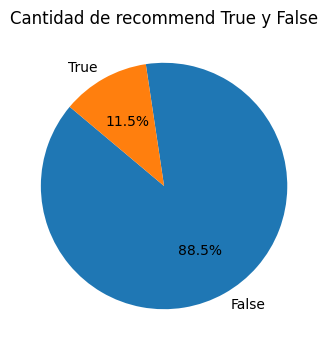

In [56]:
recommend_counts = df_rev['recommend'].value_counts()

plt.figure(figsize=(6, 4))
plt.pie(recommend_counts, labels=['False', 'True'], autopct='%1.1f%%', startangle=140)
plt.title('Cantidad de recommend True y False')
plt.show()

Con este grafico vemos que del total de las reviews, el 88.5% recomendaron un juego y el 11.5% no.

Por otro lado, utilizamos un grafico de barras horizontales para visualizar el top 10 de juegos con mayor cantidad de recomendaciones.
Para esto comenzamos agrupando segun el item_id y sumamos la cantidad de valores True por columna.

In [57]:
df_rev = df_rev.groupby('item_id', as_index=False).sum()
df_rev.head()

,item_id,recommend,Negativas,Neutras,Positivas
0,10,56,0,27,30
1,20,11,1,9,7
2,30,3,0,1,3
3,40,1,0,0,1
4,50,3,0,2,2


Obtenemos entonces el top 10 de juegos mas recomendados, y nos quedamos unicamente con los item_id para luego buscar los nombres de los juegos.


In [58]:
top_recommended = df_rev.sort_values(by='recommend', ascending=False)

titles_recommended = top_recommended['item_id']
titles_recommended.reset_index(drop=True)

0          440
1          730
2         4000
3          570
4       304930
         ...  
3677    404080
3678    209873
3679    291270
3680    404010
3681    327130
Name: item_id, Length: 3682, dtype: int32

Importamos el dataset de games

In [59]:
df_games_items = pd.read_csv('../steam_games/steam_games.csv')

In [60]:
title_games = df_games_items[['item_id', 'title']]
title_games.drop_duplicates(inplace=True)
list_item_id = []
title_for_ids = []
cant_recommend = []
for item_id in titles_recommended:
    title = title_games.loc[title_games['item_id'] == item_id, 'title'].values
    cant = df_rev.loc[df_rev['item_id'] == item_id, 'recommend'].values
    if len(title) > 0 and title[0]: 
        list_item_id.append(item_id)
        title_for_ids.append(str(title[0]))
        cant_recommend.append(cant[0])
df_top = pd.DataFrame({'item_id': list_item_id, 'title': title_for_ids, 'recommend': cant_recommend})
df_top

C:\Users\natiq\AppData\Local\Temp\ipykernel_17404\528223269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  title_games.drop_duplicates(inplace=True)


,item_id,title,recommend
0,440,Team Fortress 2,3611
1,730,Counter-Strike: Global Offensive,3478
2,4000,Garry's Mod,1685
3,570,nan,1458
4,304930,Unturned,961
...,...,...,...
3189,350150,Scraps: Modular Vehicle Combat,0
3190,404080,Murder,0
3191,291270,Vitrum,0
3192,404010,Total War: WARHAMMER - Chaos Warriors,0


Creamos el grafico de barras horizontales para visualizar.

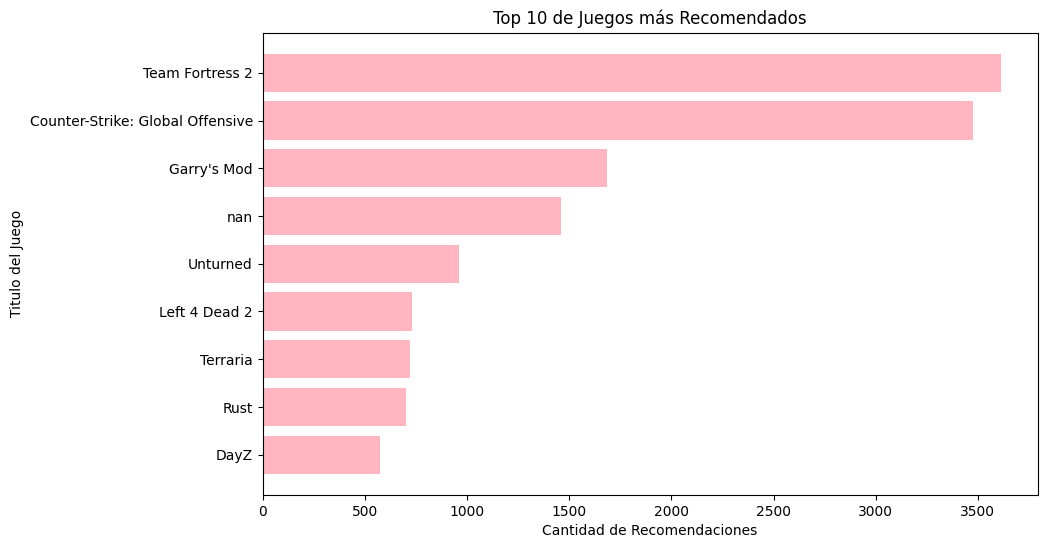

In [61]:
plt.figure(figsize=(10, 6))
plt.barh(df_top['title'].head(10), df_top['recommend'].head(10), color='lightpink')
plt.xlabel('Cantidad de Recomendaciones')
plt.ylabel('Titulo del Juego')
plt.title('Top 10 de Juegos más Recomendados')
plt.gca().invert_yaxis()
plt.show()

Por ultimo, analizamos la cantidad de reviews para cada categoria del analisis de sentimiento

In [62]:
categoria_counts = df_rev[['Negativas', 'Neutras', 'Positivas']].sum()
categoria_counts

Negativas     7294
Neutras      17605
Positivas    34406
dtype: int64

Creamos un grafico de barras

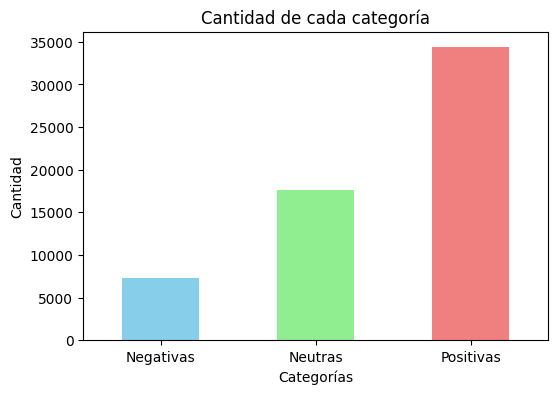

In [63]:
plt.figure(figsize=(6, 4))
categoria_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Categorías')
plt.ylabel('Cantidad')
plt.title('Cantidad de cada categoría')
plt.xticks(rotation=0)
plt.show()

# Descargamos el csv

In [26]:
user_reviews.to_csv('user_reviews.csv', index=False)